In [ ]:
# '/home/sergio/Documentos/1.- Memoria de Título 2018/Base de Datos/Control Salino/CA_EC03_NS_2018-09-05.avi'
# '/home/cmanalisis/1.- Sergio Ehijo/Control Salino/CA_EC03_NS_2018-09-05.avi'

### Esta version es más eficiente. Usa la gracia de imageio de poder iterar en todos los frames, no es necesario generar otro vector de tipo cell (matlab) para ir guardando las imagenes! jeje

### Obtener los frames del video elegido

15.0


<IPython.core.display.Javascript object>


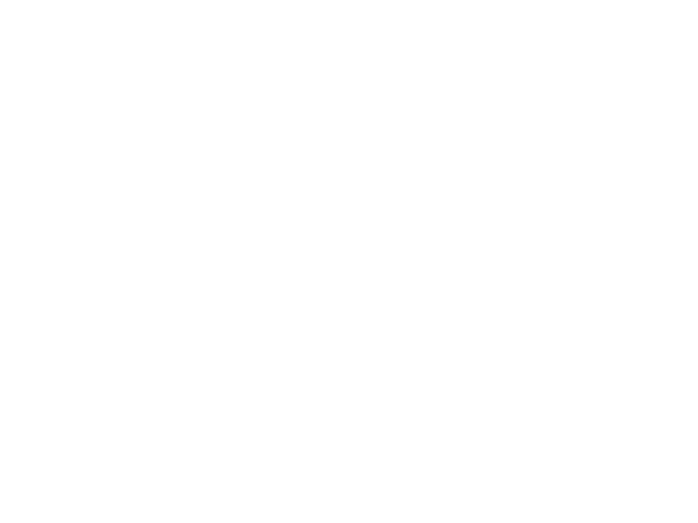

In [1]:
import numpy as np
import pickle
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# %pylab inline
#%matplotlib inline
%matplotlib notebook
#Abrir archivo
#Control Salino
#filename = '/home/cmanalisis/1_SergioEhijo/Ratas/ControlSalino/CA_EC03_NS_2018-09-05.avi'
#Alex
filename = '/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/CA_EC03_C14_NS_2018-09-12.avi'
reader = imageio.get_reader(filename)
#Obtener fps
fps = reader.get_meta_data()['fps']
print(fps)
#Graficar primer frame
imgplot = plt.imshow(reader.get_data(100))
plt.show()

In [36]:
reader.get_length()

37834

### Imponer el area elegida para la caja

In [3]:
#SETTINGS FOR WHITE BOX (THIS IS WHERE IT GETS INTERESTING)
# CONTROL SALINO
#minx = 228
#maxx = 500 
#miny = 4
#maxy = 340 

#ALEX
minx = 245
maxx = 535 
miny = 60
maxy = 410
#set the brightness threshold for what is classified as the mouse
#threshold=125;
threshold=200
#Generate the positition for each frame
x = np.zeros(reader.get_length());
y = np.zeros(reader.get_length());

### Definir funcion para calcular el centro de gravedad. La segunda función (C_gravity) es más rápida

In [ ]:
#Calculate the center of gravity for the matrix A
#Highly inefficient!!! Try not to use for large arrays/videos
def C_gravity2(A):
    moment_sum_x=0;
    moment_sum_y=0;
    Nrows, Ncolumns = A.shape 
    for i in range(Nrows-1):
        for j in range(Ncolumns-1):
            moment_sum_x=moment_sum_x+i*A[i,j]
            moment_sum_y=moment_sum_y+j*A[i,j]
    x=moment_sum_x/np.sum(np.sum(A));
    y=moment_sum_y/np.sum(np.sum(A));
    return x,y

In [4]:
def C_gravity(A):
    Nrows, Ncolumns = A.shape 
    #Ax = repmat([1:Nrows].T,1,Ncolumns);
    #Ay = repmat([1:Ncolumns],Nrows,1);
    #Se necesita una matriz. Una es 1234, 1234, 1234. La otra es 111111,222222,3333,4444
    Ax = np.tile(np.arange(Nrows).reshape((-1,1)),(1,Ncolumns))
    Ay= np.tile(np.arange(Ncolumns), (Nrows,1))
    moment_sum_x = np.multiply(A,Ax)
    moment_sum_y = np.multiply(A,Ay)
    x = np.sum(np.sum(moment_sum_x,axis=0)) / np.sum(np.sum(A,axis=0))
    y = np.sum(np.sum(moment_sum_y,axis=0)) / np.sum(np.sum(A,axis=0))
    return x,y

### Calcular el centro de gravedad para todos los frames elegidos

In [5]:
for i,im in enumerate(reader):
    x[i], y[i] = C_gravity(np.abs(threshold-np.transpose(reader.get_data(i)[miny:maxy,minx:maxx,1])))

In [6]:
len(x) # == len (y)

37834

### Ver el area elegida y lo que esta por sobre el umbral

<IPython.core.display.Javascript object>


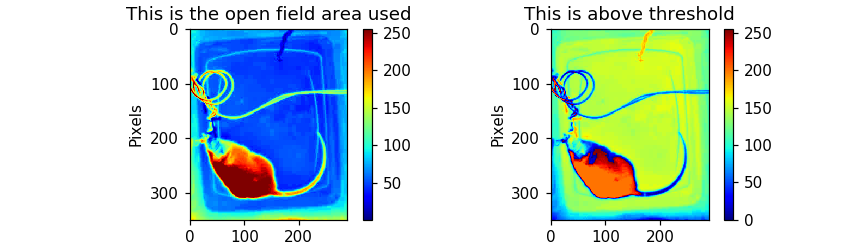

In [7]:
# Definir lo que esta por sobre el threshold
plt.figure(1)
plt.subplot(122)
plt.imshow(np.transpose(np.abs(threshold-np.transpose(reader.get_data(0)[miny:maxy,minx:maxx,1]))), cmap='jet')
#plt.imshow(np.abs(threshold-datos[0][miny:maxy,minx:maxx,1]))
plt.title('This is above threshold')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()
# Definir el area utilizada.
plt.subplot(121)
# Colormap por default es viridis
plt.imshow(np.transpose(np.transpose(reader.get_data(0)[miny:maxy,minx:maxx,1])), cmap='jet')
#plt.imshow(datos[0][miny:maxy,minx:maxx,1])
plt.title('This is the open field area used')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()
plt.show()

### Obtener la locomocion

<IPython.core.display.Javascript object>


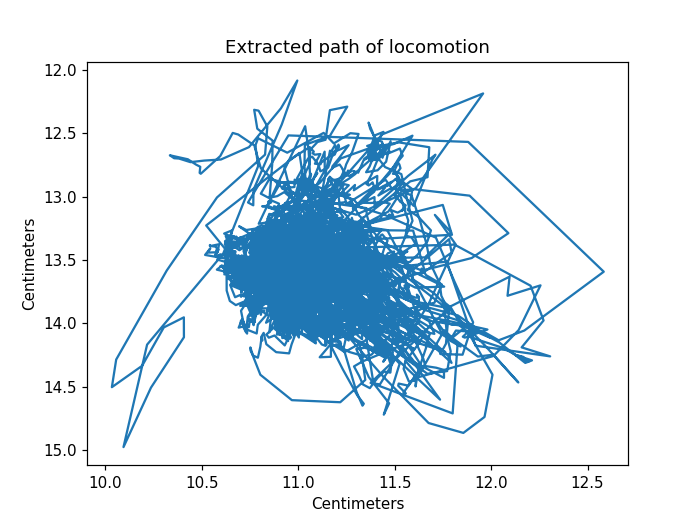

Text(0,0.5,'Centimeters')

In [17]:
# IMPORTANTE: VER TAMANO REAL DE CAJA DE MEDICION. LA caja es de 22x28 cms
# ( parte real en el cual la rata se mueve y por ende donde los pixeles se
# tomaron) . 
#In centimeters !!!!!!!!
x_scaled=(x*22)/(maxx-minx)  # pixel/frame * meter/pixel * true size = meter/frame. 
y_scaled=(y*28)/(maxy-miny) # meters. 
plt.plot(x_scaled,y_scaled)
#plt.plot(x,y)
plt.ylim(plt.ylim()[::-1])  #Invertir el sistema de coordenadas
plt.title('Extracted path of locomotion')
plt.xlabel('Centimeters')
plt.ylabel('Centimeters')

### Obtener el movimiento por cada eje OPTATIVO. Disponible en v1

### Filtrar outliers de movimiento   OPTATIVO. Disponible en v1

### Aplicar filtro pasa bajos a los vectores de trayectoria

<IPython.core.display.Javascript object>


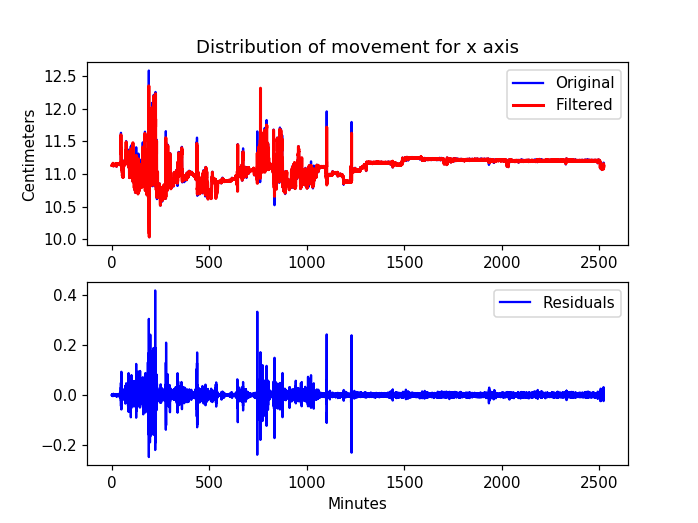

In [18]:
from scipy import signal
from scipy.signal import butter, lfilter, freqz
# First, design the Buterworth filter
N  = 4    # Filter order
fs= 5
Wn = 1/(0.5*fs) # Cutoff frequency
B, A = signal.butter(N, Wn,analog= False, output='ba')
# Second, apply the filter
temp = signal.filtfilt(B,A, x_scaled)
# Make plots
dt= 1/15
t_vec = np.arange(dt,reader.get_length()*dt + dt,dt)
#t_vec = video_frames/(fps*60)
fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.plot(t_vec,x_scaled, 'b-')
plt.plot(t_vec,temp, 'r-',linewidth=2)
plt.ylabel('Centimeters')
plt.legend(['Original','Filtered'])
plt.title("Distribution of movement for x axis")
#ax1.axes.get_xaxis().set_visible(False)
 
ax1 = fig.add_subplot(212)
plt.plot(t_vec,x_scaled-temp, 'b-')
#plt.ylabel('Centimeters')
plt.xlabel('Minutes')
plt.legend(['Residuals'])

<IPython.core.display.Javascript object>


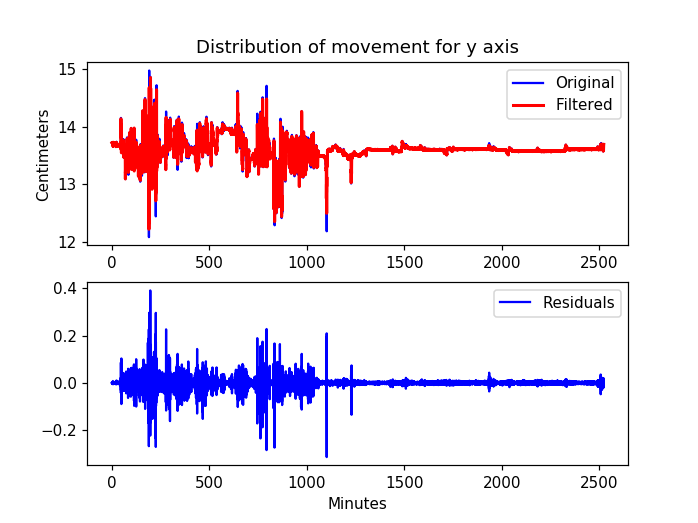

In [19]:
# First, design the Buterworth filter
N  =4    # Filter order
fs= 5
Wn =1/(0.5*fs) # Cutoff frequency
B, A = signal.butter(N, Wn,analog= False, output='ba')
# Second, apply the filter
tempy = signal.filtfilt(B,A, y_scaled)
# Make plots
fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.plot(t_vec,y_scaled, 'b-')
plt.plot(t_vec,tempy, 'r-',linewidth=2)
plt.ylabel('Centimeters')
plt.legend(['Original','Filtered'])
plt.title("Distribution of movement for y axis")
#ax1.axes.get_xaxis().set_visible(False)
 
ax1 = fig.add_subplot(212)
plt.plot(t_vec,y_scaled-tempy, 'b-')
#plt.ylabel()
plt.xlabel('Minutes')
plt.legend(['Residuals'])

<IPython.core.display.Javascript object>


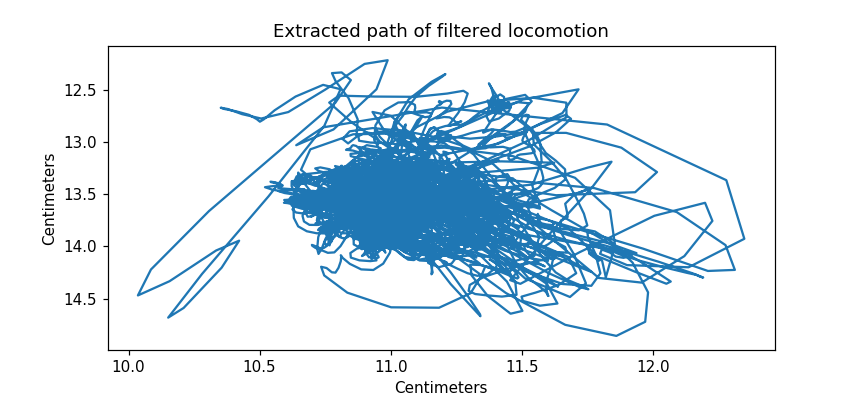

In [20]:
plt.plot(temp[1:-1],tempy[1:-1])
plt.ylim(plt.ylim()[::-1])  #Invertir el sistema de coordenadas
plt.title('Extracted path of filtered locomotion')
plt.xlabel('Centimeters')
plt.ylabel('Centimeters')
plt.show()

In [ ]:
meanx

### Calcular la velocidad y obtener su curva en el tiempo

In [22]:
def humanize_time(secs):
    mins, secs = divmod(secs, 60)
    #hours, mins = divmod(mins, 60)
    #return '%02d:%02d:%02d' % (hours, mins, secs)
    return '%02d:%02d' % (mins, secs)

        ### 'Threshold for Local Movement', 'Threshold for Displacement' in cms/s : 0.07, 0.15

<IPython.core.display.Javascript object>


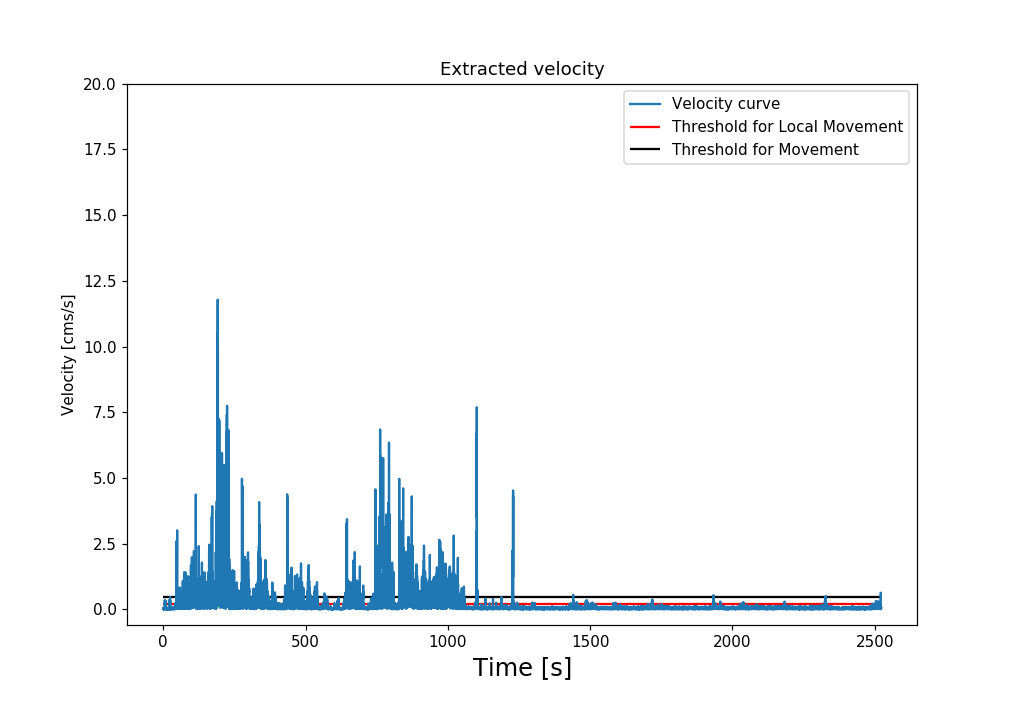

The mean is 0.18721241321150067 and the variance is 0.20967562290498035


In [23]:
vel_xfiltered  = np.square(np.diff(temp))
vel_yfiltered  = np.square(np.diff(tempy))
#Si ifi es 15, ya está en unidad de segundo porque es un fram por seg. Si se baja, se debe multiplicar por fps/ifi  (1/s) 
velfiltered    = np.sqrt(vel_xfiltered + vel_yfiltered) * fps
#Time in seconds
timetominsec = np.vectorize(humanize_time)
finaltime = timetominsec(t_vec)
# Time in minutes
#t_vec = video_frames/(fps*60)
#velfiltered = [np.mean(velfiltered) if x > 8 else x for x in velfiltered]
#[3 if math.isnan(x) else x for x in train]
#print (len(vel))
#print (len(t_vec))
plt.plot(t_vec[:-1], velfiltered)
plt.title('Extracted velocity')
plt.xlabel('Time [s]', fontsize =16)
#plt.xlabel('Minutes', fontsize =20)
plt.ylabel('Velocity [cms/s]') 
plt.ylim(top=20)
#'Threshold for Local Movement'
plt.hlines(0.21, t_vec[0],t_vec[-1], colors='red')
#'Threshold for Displacement'
plt.hlines(0.45, t_vec[0],t_vec[-1], colors='black')
plt.legend(['Velocity curve','Threshold for Local Movement', 'Threshold for Movement'])
print('The mean is {} and the variance is {}'.format(np.mean(velfiltered),np.var(velfiltered)))

### Desde aquí, viene todo lo que es sliding window!

### Es necesario buscar en que segundo se prende el led, y en que segundo emite el segundo pulso. 

In [64]:
%matplotlib inline
#imgplot = plt.imshow(reader.get_data(238))
# En el frame 238 original se enciende por primera vez el LED; segundo 15.86667 es el 
# origen. Esto es entre el fram 79 y 80 de este vector con el que se esta trabajando
#imgplot = plt.imshow(reader.get_data(238))
final_vel =  velfiltered[238:]

37595

In [66]:
# LMT = Local Movement threshold
LMT = 0.21
vel_bigger = (x > LMT for x in final_vel)
print( sum(vel_bigger))
print( len(final_vel) )

7632
37595


In [86]:
15*330/1000
# Son 15 frames. El step será de 10 para que sea lo más cercano a 300 ms. De hecho se estan tomando alrededor 
# 333 ms de traslape.

4.95

In [2]:
def slidingWindow(sequence,winSize,step=1):
    """Returns a generator that will iterate through
    the defined chunks of input sequence.  Input sequence
    must be iterable."""
 
    # Verify the inputs
    try: it = iter(sequence)
    except TypeError:
        raise Exception("**ERROR** sequence must be iterable.")
    if not ((type(winSize) == type(0)) and (type(step) == type(0))):
        raise Exception("**ERROR** type(winSize) and type(step) must be int.")
    if step > winSize:
        raise Exception("**ERROR** step must not be larger than winSize.")
    if winSize > len(sequence):
        raise Exception("**ERROR** winSize must not be larger than sequence length.")
 
    # Pre-compute number of chunks to emit
    # Es importante que numOfChunks sea int. Por ende la operacion divmod seapara en parte entera y decimal, con 
    # el segundo argumento (1) que indica la cantidad de decimales de d-
    numOfChunks,d = divmod(((len(sequence)-winSize)/ step)+1,1)
    #As int
    numOf = int(numOfChunks)
    # Do the work
    for i in range(0,numOf*step,step):
        yield sequence[i:i+winSize]
    # Para el caso particular de considerar el ultimo pedazo de tiempo que puede ser mas corto debido a que la 
    # ventana no lo cubre, se tiene el siguiente if. Si no es necesario, comentar. 
    #if (d!=0):
     #   yield sequence[numOf*step:]

## LMT = Local Movement threshold

In [3]:
sequence2 = np.array([1,12,10,5,7,8,1,2,20,22,23])
#sequence = np.array([1,1,1,1,1,1,1,1,1])
# vel_bigger = (x > LMT for x in final_vel)
winSize = 5
step = 3
chunks = slidingWindow(sequence2,winSize,step)
suma = 0
for chunk in chunks:    
    print(chunk)
    #suma = suma +np.sum(chunk)
#print (suma)

[ 1 12 10  5  7]
[5 7 8 1 2]
[ 1  2 20 22 23]


### El siguiente método sirve para generar el vector de tags 

In [37]:
final_vel =  velfiltered[238:]
LMT = 0.21
winSize = 15
step = 10
chunks = slidingWindow(final_vel,winSize,step)
tags = []
for chunk in chunks:
    #print(chunk)
    suma = 0
    for vel in chunk:
        if (vel > LMT):
            suma = suma +1
    #print(suma)
    if (suma != 0):
        #TAG 1 : Movimiento.
        tags = np.append(tags, 1)
    else:
        #TAG 0 : Quieto.
        tags = np.append(tags, 0)

In [42]:
print(sum(tags))
print(len(tags))
tags[100:115]

1275.0
3759


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [44]:
import pickle
# guardar el data frame con los tags de movimiento a un archivo pickle
# poner aqui nombre del archivo pickle que se quiere guardar
file2save = 'CA_EC03_C14'
#Para python3, raw_input paso a ser input()
#answer = raw_input('Cambió el nombre del archivo de output? (s/n):')
rootpath2 = '/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/Pickles/'
answer = input('Cambió el nombre del archivo de output? (s/n):')
if answer == 'n':
    print ('Entonces cambielo')
elif answer == 's':
    print ('Guardando...')
    pickle.dump([tags], open( rootpath2 + 
                          'MovementTags_' + file2save + '.pickle', "wb" ) )
    # print('Archivo',file2save)
else:
    print ('Entonces cambielo')
    

Cambió el nombre del archivo de output? (s/n):s
Guardando...
